# Grade: /100 pts

# Assignment 05: Model Selection & Cross Validation

In this assignment you will be using a #TidyTuesday dataset on Spotify songs to build a classification model for predicting Spotify song popularity.

The dataset has already been preprocessed, and is ready to be used! 

The Spotify songs dataset has provided you with data for 30947 Spotify songs.  Your job: build a model or models, perform model selection using cross validation techniques, and evaluate your final selected model.

### The Dataset

The data is stored in a csv file called `spotify_pre.csv`.  The data includes some information about playlist genre, playlist subgenre, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, and duration. The target variable is `track_popularity`, which has two categories `high` and `low`.


### Follow These Steps before submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline. 

5.  Your submission document should be saved in the form: `LastName_FirstName_Assignment5.ipynb`

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import make_scorer, mean_squared_error,roc_curve, auc, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin

pd.set_option('display.max_columns', 500)
plt.style.use('ggplot')
%matplotlib inline

_____

### Question 1: /15pts

First, import the dataset `spotify_pre.csv` as a dataframe and print out a few rows and get metadata of the csv file to have a rough understanding of the type of each column.

In [2]:
# Import the dataset etc.

# read dataset
data_set = pd.read_csv(filepath_or_buffer='spotify_pre.csv')
print('=' * 100)
print('Length of Dataset: {}'.format(len(data_set)))

# all features' name except target
list_all_columns = data_set.columns.to_list()
list_all_columns.remove('track_popularity')

# print first 5 rows
print('=' * 100)
print(data_set.head(5))

# print infomation such as name and type of each column
print('=' * 100)
print(data_set.info())

print('=' * 100)
# calculate baseline accuracy
count_popularity = data_set['track_popularity'].value_counts()
print('Number of Low and High label:')
print(count_popularity)
max_label_count = count_popularity['low']
min_label_count = count_popularity['high']
base_line_acc = max_label_count/(min_label_count + max_label_count)
print("> Baseline Accuracy: {}".format(base_line_acc.round(1)))

Length of Dataset: 30947
  track_popularity playlist_genre playlist_subgenre  danceability  energy  \
0              low            pop         dance pop         0.748   0.916   
1              low            pop         dance pop         0.726   0.815   
2             high            pop         dance pop         0.675   0.931   
3              low            pop         dance pop         0.718   0.930   
4              low            pop         dance pop         0.650   0.833   

   key  loudness   mode  speechiness  acousticness  instrumentalness  \
0    6    -2.634  major       0.0583        0.1020          0.000000   
1   11    -4.969  major       0.0373        0.0724          0.004210   
2    1    -3.432  minor       0.0742        0.0794          0.000023   
3    7    -3.778  major       0.1020        0.0287          0.000009   
4    1    -4.672  major       0.0359        0.0803          0.000000   

   liveness  valence    tempo  duration_m  
0    0.0653    0.518  122.036    3.

Finally create a barchart of playlist_subgenre with each bar showing the proportion of track_popularity categories (use ggplot with 'fill' option set to 'track_popularity'). Make sure to flip cartesian coordinates so that horizontal becomes vertical, and vertical, horizontal.

**Make sure to check out some online resources for plotting with ggplot in Python**

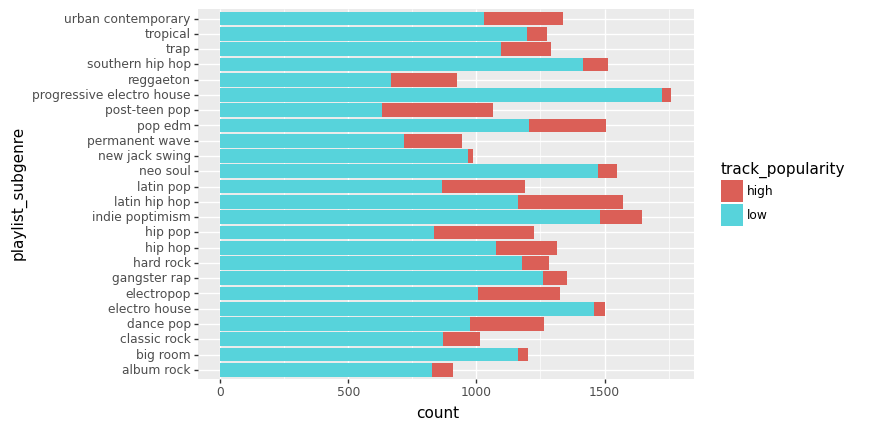

<ggplot: (8764868647129)>

In [3]:
# Code to construct the barchart
ggplot(data_set, aes(x='playlist_subgenre', fill='track_popularity')) + geom_bar(stat = 'count') + coord_flip()

Which category of playlist_subgenre is more likely to gain popularity?

**ANSWER HERE: According to the plot, post-teen pop is more likely to gain popularity.**


_____________

### Question 2: /10pts


Now, you will create boxplots with x axis set to `playlist_genre` and y axis set to `instrumentalness` and color option set to `track_popularity`. Make sure to change the y axis scale into log10 scale for a better representation.

/home/farhad-bat/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
/home/farhad-bat/.local/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 11500 rows containing non-finite values.


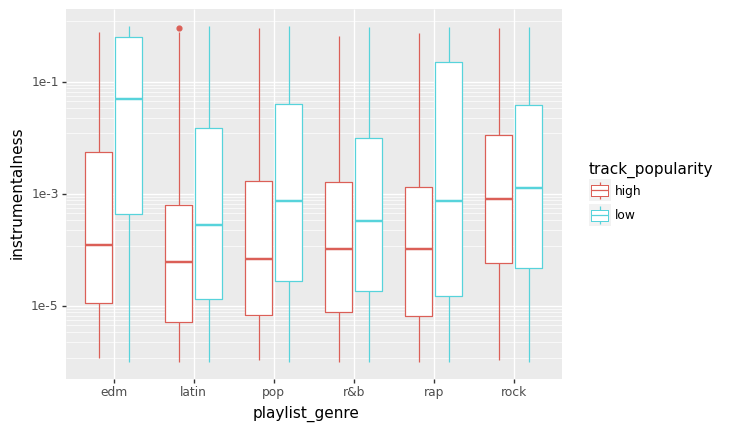

<ggplot: (8764868690155)>

In [4]:
## Your code
ggplot(data_set, aes(x='playlist_genre', y='instrumentalness', color='track_popularity')) + geom_boxplot() + scale_y_continuous(trans='log10')

With track_popularity taken into account, does instrumentalness score differ within some of playlist genres?

**ANSWER HERE: In some of the genres, the instrumentalness score is similar for both low and high popular songs; however, in some genres such as edm, the score for two track_popularity is highly different.**

___________

### Question 3: /10

Create a basic logistic regression model (with default penalization) named `model1`. You need to create a model pipeline to be fit later. (Use `solver='lbfgs'`, `max_iter=10000` and `random_state=0`)

The predictor variables are `mode`, and `loudness`. Use the following chunk of code. You will use `Data1` to build your model.

In [5]:
# Your code
# Hints:
#Data1 = spotify_pre[['track_popularity', 'mode', 'loudness']] 
#Data1 = pd.get_dummies(Data1, drop_first=True) 
#Data1 = Data1.rename({'track_popularity_low': 'track_popularity'}, axis='columns') 
#Data1.head()

# prepare Data1
Data1 = data_set[['mode', 'loudness', 'track_popularity']]
Data1 = pd.get_dummies(data=Data1, drop_first=True)
Data1 = Data1.rename({'track_popularity_low':'track_popularity', 'mode_minor':'mode'}, axis='columns')
print('>    Data1 dataframe first 5 rows:')
print(Data1.head(5))

Data1_all_X = Data1[['loudness', 'mode']]
Data1_all_y = Data1[['track_popularity']].values.ravel()
print('>    Data1 X first 5 rows:')
print(Data1_all_X.head(5))
print('>    Data1 y first 5 rows:')
print(Data1_all_y[0:5])

# create model1
model1 = Pipeline([
    ('linear_regression', LogisticRegression(solver='lbfgs', max_iter=10000, random_state=0))
])


>    Data1 dataframe first 5 rows:
   loudness  mode  track_popularity
0    -2.634     0                 1
1    -4.969     0                 1
2    -3.432     1                 0
3    -3.778     0                 1
4    -4.672     0                 1
>    Data1 X first 5 rows:
   loudness  mode
0    -2.634     0
1    -4.969     0
2    -3.432     1
3    -3.778     0
4    -4.672     0
>    Data1 y first 5 rows:
[1 1 0 1 1]


Now that you have created the pipeline, fit `model1` for predicting the target variable, track_popularity, with the two predictors. Use a 70/30 train-test split of the data, remember to set `random_state=0` in the function `train_test_split`. After that, evaluate this model plotting the ROC curve and reporting the AUC value. 

In [6]:
# np.random.seed(0);np.random.rand(5)

# Create the training and test data
Data1_X_train, Data1_X_test, Data1_y_train, Data1_y_test = train_test_split(Data1_all_X, Data1_all_y, test_size=0.3, random_state=0)

#Fit the model1 with training set of Data1
model1.fit(Data1_X_train, Data1_y_train)
print('model1 classes: {}'.format(model1.classes_))

# predict probability of Data1 test
Data1_y_test_pred_prob = model1.predict_proba(Data1_X_test)

model1 classes: [0 1]


Model1 AUC: 0.5655928257416746
Dataset baseline accuracy: 0.8492584095388891
Model1 Accuracy: 0.850942380183091


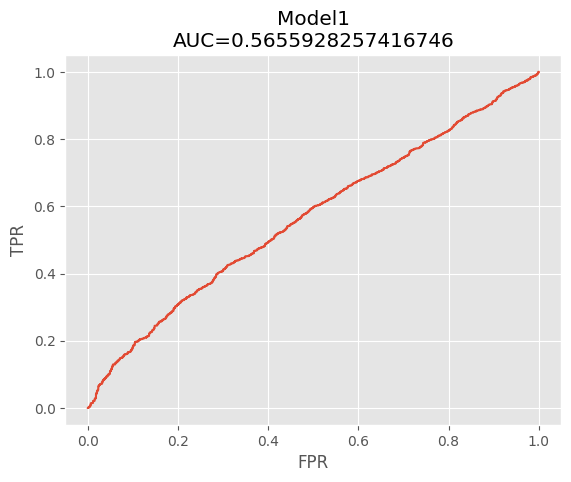

In [7]:
# Create the ROC curve and report AUC
fpr, tpr, _ = roc_curve(y_true=Data1_y_test, y_score=Data1_y_test_pred_prob[:,1], pos_label=model1.classes_[1])
model1_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Model1\nAUC={}'.format(model1_auc))
print('Model1 AUC: {}'.format(model1_auc))

from sklearn.metrics import accuracy_score
model_1_accuracy = accuracy_score(y_true=Data1_y_test, y_pred=model1.predict(Data1_X_test))
print('Dataset baseline accuracy: {}'.format(base_line_acc))
print('Model1 Accuracy: {}'.format(model_1_accuracy))


At this point, would you use the baseline model as your final model? Why or why not?

**ANSWER HERE: In question (1), I calculated the baseline accuracy, which it is 0.8. The model1 performance as it depicted in the above figure is very poor and near to y=x line. Model1 is not a good classifier. Model1 accuracy is 0.850 while baseline accuracy is 0.849. They are almost the same. It means Model1's performance is euql to always reporting the label of most occuring label (low popularity). **

____________

### Question 4: /40

Here, we want to determine the best single numeric feature model to predict the track_popularity. To be specific, you are going to create a model per each predictor: 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_m'. Make sure to use the cross-validation technique to make your decision. Please make sure to use 'pd.get_dummies(, drop_first=True)' to encode the target variable, and change the column name 'track_popularity_low' to 'track_popularity', as in previous question.

You remember that *cross-validation* technique is used to find the expected test error of the models. In addition, in the next code, 5 different folds are displayed using 5 fold cross-validation. In this case it is used `StratifiedKFold()` function.

#### 4.1: /5
**Define a function `AUC_calculation` with inputs `(X, y, index_train, index_test)`  which calculates the AUC of the `model1` trained on `index_train` and tested on `index_test`.**

In [8]:
# Your code
# Hints:
#str_kf = StratifiedKFold(n_splits=5) for j, (index_train, index_test) in enumerate(str_kf.split(X,y)):

 ##enumerate has the index and the elements in the folds
 ##print(k, (index_train, index_test))
#plt.plot(index_train, [j+1 for s in index_train], '.')
#plt.title('Cross Validation ')

def AUC_calculation(X, y, index_train, index_test):

    # seperate train and validation folds
    X_trainset = X.loc[index_train]
    y_trainset = y[index_train]
    X_valset = X.loc[index_test]
    y_valset = y[index_test]

    # train model
    model1.fit(X_trainset, y_trainset)
    
    # predict probability of val set
    y_valset_pred_prob = model1.predict_proba(X_valset)

    # Create the ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true=y_valset, y_score=y_valset_pred_prob[:,1], pos_label=model1.classes_[1])
    model_auc = auc(fpr, tpr)

    return model_auc


In [9]:
str_kf = StratifiedKFold(n_splits=5)

for j, (index_train, index_test) in enumerate(str_kf.split(Data1_X_train,Data1_y_train)):
    print(Data1_y_train)

[1 1 1 ... 1 1 0]
[1 1 1 ... 1 1 0]
[1 1 1 ... 1 1 0]
[1 1 1 ... 1 1 0]
[1 1 1 ... 1 1 0]


#### 4.2: /8
**Using `AUC_calculation` create a function named `AUC_cross_validation` which has as input (X, y, n_fold). `AUC_cross_validation` does a `n_fold` cross validation (using `StratifiedKFold`) and its output should be a list with the AUC for each fold.** 

In [10]:
# Your code

def AUC_cross_validation(X, y, n_fold):

    all_auc = []

    # object for creating folds
    kf_obj = StratifiedKFold(n_splits=n_fold)
    
    # for each fold calculate AUC score
    for idx, (index_train, index_val) in enumerate(kf_obj.split(X,y)):
        
        # calculate auc
        auc_i = AUC_calculation(X=X, y=y, index_train=index_train, index_test=index_val)
        all_auc.append(auc_i)

    # convert to  numpy
    all_auc = np.array(all_auc)

    return all_auc

#### 4.3: /5
**Now you are ready to estimate and compare through cross validation the performance of all the *simple models* that only use one numeric predictor as input. Prepare you dataset here!**

In [11]:
# Your code

# just keep numerical values and prepare target class
list_numeric_columns = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_m']
Data_numeric = data_set[list_numeric_columns + ['track_popularity']]
Data_numeric = pd.get_dummies(data=Data_numeric, drop_first=True)
Data_numeric = Data_numeric.rename({'track_popularity_low':'track_popularity'}, axis='columns')

print(Data_numeric.head())

   danceability  energy  key  loudness  speechiness  acousticness  \
0         0.748   0.916    6    -2.634       0.0583        0.1020   
1         0.726   0.815   11    -4.969       0.0373        0.0724   
2         0.675   0.931    1    -3.432       0.0742        0.0794   
3         0.718   0.930    7    -3.778       0.1020        0.0287   
4         0.650   0.833    1    -4.672       0.0359        0.0803   

   instrumentalness  liveness  valence    tempo  duration_m  track_popularity  
0          0.000000    0.0653    0.518  122.036    3.245900                 1  
1          0.004210    0.3570    0.693   99.972    2.710000                 1  
2          0.000023    0.1100    0.613  124.008    2.943600                 0  
3          0.000009    0.2040    0.277  121.956    2.818217                 1  
4          0.000000    0.0833    0.725  123.976    3.150867                 1  


#### 4.4: /8

**Use your function `AUC_cross_validation` to compute cross-validation estimates of the AUC for each single numeric feature model, use a data frame (named `AUC_models`) to report the AUC value for each fold and each of the models. (Use `n_fold=10`).**

**The column names of `AUC_models` have to be in the form `Simple-numeric predictor variable`, e.g., `simple-tempo`.**

In [12]:
# Construct AUC_models dataframe

df_one_feature_result = pd.DataFrame()

# for each feature
for feature_name in list_numeric_columns:

    # create X, y by a numeric feature and target
    X_all_one_feature = Data_numeric[[feature_name]]
    y_all_one_feature = Data_numeric[['track_popularity']].values.ravel()
    
    # calculate
    folds_results = AUC_cross_validation(X=X_all_one_feature, y=y_all_one_feature, n_fold=10)
    df_one_feature_result['Simple-'+feature_name] = folds_results

In [13]:
# Print AUC_models dataframe 
print(df_one_feature_result)

   Simple-danceability  Simple-energy  Simple-key  Simple-loudness  \
0             0.555868       0.607359    0.481996         0.553269   
1             0.487477       0.357881    0.529757         0.709963   
2             0.464991       0.579237    0.516969         0.528699   
3             0.751291       0.553775    0.457959         0.624714   
4             0.469592       0.568940    0.527370         0.435774   
5             0.458676       0.552932    0.514861         0.585892   
6             0.643550       0.394638    0.487751         0.745097   
7             0.527566       0.446832    0.513050         0.690803   
8             0.580350       0.867400    0.518115         0.338044   
9             0.542105       0.674315    0.495095         0.468274   

   Simple-speechiness  Simple-acousticness  Simple-instrumentalness  \
0            0.458888             0.597392                 0.631633   
1            0.418472             0.370703                 0.663520   
2            0.2

#### 4.5: /7

**Decide which of the studied models has the best and the worst performance, using a boxplot (without presenting outliers) that shows the distribution of the previous AUC scores for every model.** (Do not forget labels!)

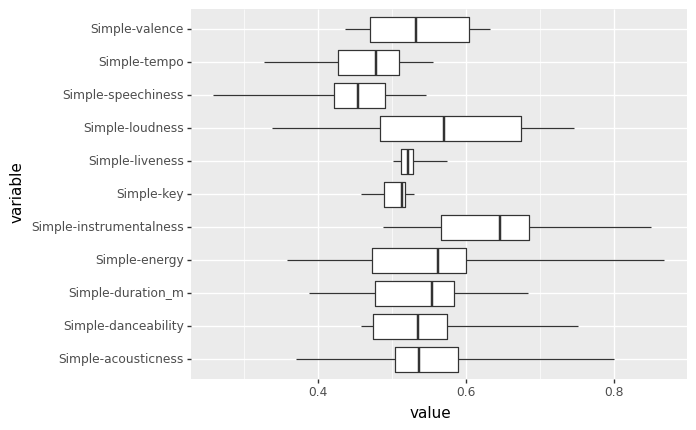

<ggplot: (8764866320909)>

In [14]:
# Code to plot the boxplots organized as required
df_melted = pd.melt(df_one_feature_result)
# ggplot(df_melted, aes(x='variable', y='value')) + geom_boxplot() + coord_flip()

# create boxplot where whiskers extend to max and min values
ggplot(df_melted, aes(y = 'value')) + geom_boxplot(aes(x = 'variable'), coef = 500) + coord_flip()

**ANSWER HERE: According to the boxplot, the model that works with 'instrumentalness' feature has the highlest AUC scores, so it is better. It median, 25 percentile, 75 percentile, etc is higher than others. The worst performance belong to Simple-speechiness.**

#### 4.6: /7
**Now, lets compare these models with the one including all the numeric variables** 

**You again will use  10-fold cross-validation to determine if this new model has better performance, and at the end, you want to plot the boxplots with the information of this new model.**  

In [15]:
# Your code
# create X, y by a numeric feature and target
X_all_numeric_feature = Data_numeric[list_numeric_columns]
y_all_numeric_feature = Data_numeric[['track_popularity']].values.ravel()

# calculate
folds_results = AUC_cross_validation(X=X_all_numeric_feature, y=y_all_numeric_feature, n_fold=10)
df_one_feature_result['model-'+ 'all-numeric-features'] = folds_results

# Print the new data frame 
print(df_one_feature_result)

   Simple-danceability  Simple-energy  Simple-key  Simple-loudness  \
0             0.555868       0.607359    0.481996         0.553269   
1             0.487477       0.357881    0.529757         0.709963   
2             0.464991       0.579237    0.516969         0.528699   
3             0.751291       0.553775    0.457959         0.624714   
4             0.469592       0.568940    0.527370         0.435774   
5             0.458676       0.552932    0.514861         0.585892   
6             0.643550       0.394638    0.487751         0.745097   
7             0.527566       0.446832    0.513050         0.690803   
8             0.580350       0.867400    0.518115         0.338044   
9             0.542105       0.674315    0.495095         0.468274   

   Simple-speechiness  Simple-acousticness  Simple-instrumentalness  \
0            0.458888             0.597392                 0.631633   
1            0.418472             0.370703                 0.663520   
2            0.2

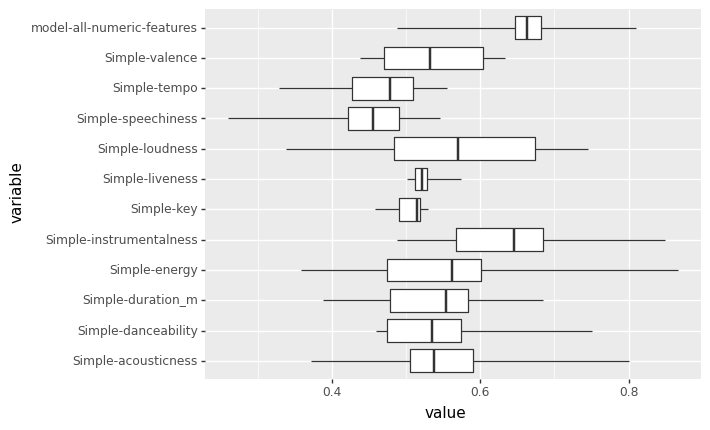

<ggplot: (8764866212319)>

In [16]:
# Plot the boxplots
# Code to plot the boxplots organized as required
df_melted = pd.melt(df_one_feature_result)
# ggplot(df_melted, aes(x='variable', y='value')) + geom_boxplot() + coord_flip()

# create boxplot where whiskers extend to max and min values
ggplot(df_melted, aes(y = 'value')) + geom_boxplot(aes(x = 'variable'), coef = 500) + coord_flip()

_____________

### Question 5: /10

Finally, you are going to include all the numeric predictors as well as the categorical variable `mode` in the model. Make sure to encode the categorical variable. Use the 10-fold cross-validation to evaluate the performance of this model. Print the AUC mean for all the models (including previous models) in ascending order.

In [17]:
# Your code

# praper data
Data_all = data_set.copy()
Data_all = pd.get_dummies(data=Data_all, drop_first=True)
Data_all = Data_all.rename({'track_popularity_low':'track_popularity'}, axis='columns')


# create X, y by all features and target
X_all_all_feature = Data_all.drop(columns=['track_popularity'])
y_all_all_feature = Data_all[['track_popularity']].values.ravel()

# calculate
folds_results = AUC_cross_validation(X=X_all_all_feature, y=y_all_all_feature, n_fold=10)
df_one_feature_result['model-'+ 'all-features'] = folds_results

# Print the new data frame 
print(df_one_feature_result)

# Print the new data frame 

   Simple-danceability  Simple-energy  Simple-key  Simple-loudness  \
0             0.555868       0.607359    0.481996         0.553269   
1             0.487477       0.357881    0.529757         0.709963   
2             0.464991       0.579237    0.516969         0.528699   
3             0.751291       0.553775    0.457959         0.624714   
4             0.469592       0.568940    0.527370         0.435774   
5             0.458676       0.552932    0.514861         0.585892   
6             0.643550       0.394638    0.487751         0.745097   
7             0.527566       0.446832    0.513050         0.690803   
8             0.580350       0.867400    0.518115         0.338044   
9             0.542105       0.674315    0.495095         0.468274   

   Simple-speechiness  Simple-acousticness  Simple-instrumentalness  \
0            0.458888             0.597392                 0.631633   
1            0.418472             0.370703                 0.663520   
2            0.2

In [18]:
# Print the AUC mean for each of the models in ascending order
print(df_one_feature_result.mean(axis='index').sort_values())

model-all-features            0.212821
Simple-speechiness            0.432759
Simple-tempo                  0.460445
Simple-key                    0.504292
Simple-liveness               0.524621
Simple-duration_m             0.532453
Simple-valence                0.535569
Simple-danceability           0.548147
Simple-energy                 0.560331
Simple-acousticness           0.562292
Simple-loudness               0.568053
Simple-instrumentalness       0.633427
model-all-numeric-features    0.660309
dtype: float64


Which of the above models is the best model? Why? 

**ANSWER HERE:** According to mean value of cross validation AUC, 'model_all_numeric_features' model which use all numerical features outperform all other models in term of mean AUC. Therefore, it is better.


______________

### Question 6: /15pts

Now it is time to train it on all the training data. Estimate the performance of this model on the test data and do the following (For this, use a 70/30 train-test split of the data, remember to set `random_state=0` in the function `train_test_split` ): 

- Use boostrap technique to find the 95% CI for the AUC. 
- Plot the distribution of the boostrap AUC scores.

model1 classes: [0 1]
Model All Numeric AUC (Test Set): 0.6948785201697598


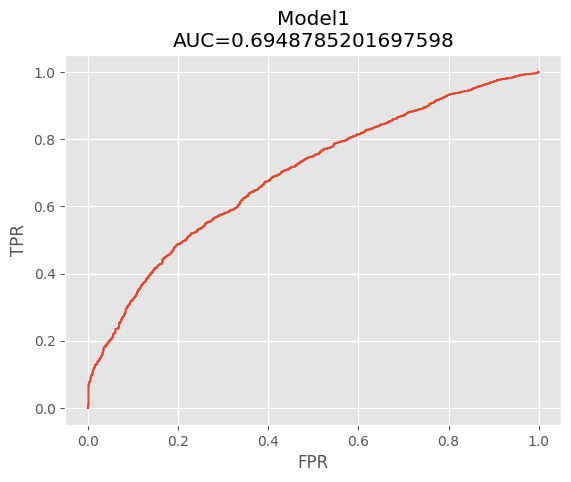

In [19]:
# Your code

Data_best = data_set[list_numeric_columns + ['track_popularity']]
Data_best = pd.get_dummies(data=Data_best, drop_first=True)
Data_best = Data_best.rename({'track_popularity_low':'track_popularity'}, axis='columns')
Data_best_all_X = Data_best[list_numeric_columns]
Data_best_all_y = Data_best[['track_popularity']].values.ravel()


# Create the training and test data
Data_best_X_train, Data_best_X_test, Data_best_y_train, Data_best_y_test = train_test_split(Data_best_all_X, Data_best_all_y, test_size=0.3, random_state=0)

#Fit the model1 with training set of Data1
model1.fit(Data_best_X_train, Data_best_y_train)
print('model1 classes: {}'.format(model1.classes_))

# predict probability of Data1 test
Data_best_y_test_pred_prob = model1.predict_proba(Data_best_X_test)

fpr, tpr, _ = roc_curve(y_true=Data_best_y_test, y_score=Data_best_y_test_pred_prob[:,1], pos_label=model1.classes_[1])
model_best_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Model1\nAUC={}'.format(model_best_auc))
print('Model All Numeric AUC (Test Set): {}'.format(model_best_auc))

In [20]:
# Your code
bootstrap_n = 1000

# number of data in test set
num_rows = len(Data_best_y_test)

# predict probability for test data
Data_best_y_test_pred = model1.predict_proba(Data_best_X_test)[:, 1]

bootstrapping_auc = []

for i in range(bootstrap_n):
    
    # sampling with replacement
    idxs = np.random.choice(a=np.arange(0, num_rows), replace=True, size=(num_rows))
    sampled_y_test = Data_best_y_test[idxs]
    sampled_y_test_pred = Data_best_y_test_pred[idxs]

    fpr, tpr, _ = roc_curve(y_true=sampled_y_test, y_score=sampled_y_test_pred, pos_label=model1.classes_[1])
    model_simple_best_auc = auc(fpr, tpr)

    bootstrapping_auc.append(model_simple_best_auc)

bootstrapping_auc = np.array(bootstrapping_auc)


# calculate confidence level
boot_CL = 95/100
p1 = (1-boot_CL)/2
p2 = 1- p1

# calculate quantile
boot_quant = np.quantile(bootstrapping_auc-model_best_auc, [p1, p2])

boot_ci = [model_best_auc + boot_quant[0], model_best_auc + boot_quant[1]]
print('>    Confidence Interval with bootsrapping for CL of 95%: {}'.format(boot_ci))


>    Confidence Interval with bootsrapping for CL of 95%: [0.6807492708615103, 0.7082172658768904]


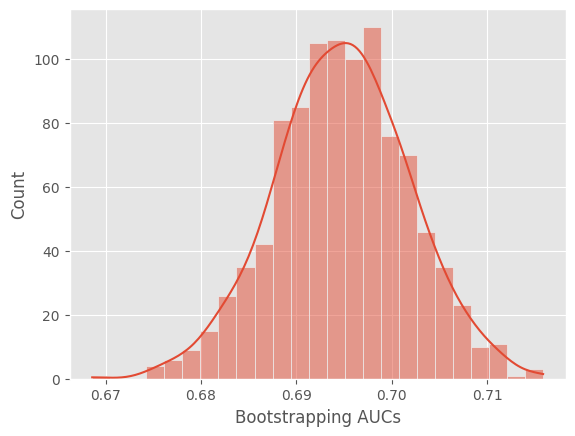

In [21]:
# Your code
sns.histplot(data=bootstrapping_auc, kde=True)
plt.xlabel('Bootstrapping AUCs')
plt.show()

Is the test AUC close to the AUC cross validation of the model you chose? Why do you think this is the case?

**ANSWER HERE:** The AUC of the model with cross valication is 0.660828 and in this part its AUC is 0.6948175232812411. These two are similar and close. They are close because (1) both of them recieve similar size of data for training. (2) the amount of data in both case and complexity of model is enough to reach an acceptable generilization in this problem. (3) We have data leakage, we used whole data with cross validation to select a model. Then, we split the data into two parts train and test.